# Mean Maximum Discrepancy

En este cuaderno vamos a explorar la detección de *data drift* utilizando el método **Maximum Mean Discrepancy (MMD)**. Para ello compararemos distintos conjuntos de datos sintéticos y evaluaremos no solo la magnitud de la diferencia entre sus distribuciones, sino también si dicha diferencia es significativa mediante tests de permutación. El objetivo es entender cómo se calcula el drift, cómo se interpreta el p-valor y en qué casos podemos afirmar que dos muestras provienen de distribuciones distintas.


In [42]:
# Para este notebook hay que tener instalado numpy, scikit-learn, matplotlib y frouros

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt


from scipy.spatial.distance import pdist

from frouros.detectors.data_drift import MMD
from frouros.utils.kernels import rbf_kernel

from functools import partial

In [43]:
# El data drift busca determinar si dos conjuntos de datos pertenecen a una misma distribución. Es decir, si son similares.
# Esto requiere no solo medir la diferencia entre los dos conjuntos de datos, sino saber si la diferencia es significativa
# y no un fruto del azar.

# Para medir la diferencia (magnitud) se emplean distintas técnicas, pero para saber si son significativas o no las magnitudes
# se emplean teses de permutación.

# Para realizar estos teses se toma la magnitud de drift calculada entre los conjuntos de datos como magnitud crítica.
# Después, se combinan ambos conjuntos de datos y aleatoriamente se toman otros dos. Sobre estos se vuelve a calcular la magnitud
# del drift y se le denomina magnitud observada.

# La proporción de veces que la magnitud observada es inferior a la magnitud crítica nos dice la probabilidad de significancia del drift.
# A este valor se le llama p_value en la literatura, cuanto mayor es su valor mayor es la probabilidad de que el drift sea fruto del azar y,
# cuanto menor es, más significativo es el drift.

# Por eso, antes de empezar los experimentos hay que definir un umbral para el test de permutación. Siendo lo más estandar en la literatura usar 0.05.

TRESHOLD= 0.05

In [44]:
# Como vamos a ver la detección de data drift con varios conjuntos de datos lo hemos instanciado como un metodo.
# Recibirá un sample_a como conjunto de datos de referencia y un sample_b como el de test. Además se harán K permutaciones,
# que por defecto hemos definido como 100. 

def mmd_drift_computation(sample_a, sample_b, K = 100):

    # Para calcular el drift entre dos conjuntos de vectores con MMD vamos a seguir los siguientes pasos.


    # 1. Identificamos las muestras de referencia y test. 
    # También guardamos su tamaño porque más adelante hay que tenerlo en cuenta.
    reference_sample= sample_a
    reference_sample_size= len(sample_a)

    test_sample= sample_b
    test_sample_size= len(sample_b)


    # El método de MMD requiere de un kernel. Lo más común es utilizar RBF, como haremos en este estudio.
    # Para utilizar este kernel, hay que establecer un parámetro llamado sigma_median, que cumple una función de
    # nivel de zoom para MMD. Este valor permite a MMD ajustar la búsqueda de diferencias a una escala particular.
    # 
    # Por eso, MMD es depende en gran medida de este valor, por lo que su selección no puede ser arbitraria. 
    # La heurística más seguida en la literatura define este nivel de zoom (sigma_median) como la mediana de la
    # distancia entre todos los vectores. 
    #
    # Esto se ve aplicado de la siguiente forma:
    complete_sample= np.vstack([reference_sample, test_sample])
    pairwise_dists = pdist(complete_sample, metric="euclidean")
    sigma_median = np.median(pairwise_dists)


    # Ahora instanciamos el kernel que vamos a utilizar para MMD de la siguiente forma, ya que lo vamos a llamar en
    # repetidas ocasiones.
    custom_kernel = partial(rbf_kernel, sigma=sigma_median)


    # Con el kernel instanciado y las muestras de datos listas, podemos crear ya el detector MMD
    detector = MMD(kernel=custom_kernel)

    # Este detector lo entrenamos con los datos de referencia
    detector.fit(X=reference_sample)

    # Y ahora buscamos las diferencias con los datos de test.
    result, _ = detector.compare(X=test_sample)

    # El resultado es un número que representa la magnitud de la diferencia entre los dos conjuntos.
    # Sin embargo, esta magnitud no aporta ningún detalle sobre si los datos son diferentes o son parecidos.
    drift_magnitude = abs(result.distance)

    # Para saber si la magnitud es significativa, es decir, que prueba que los dos conjuntos de datos son diferentes, hay 
    # que llevar a cabo un test de permutación. Esto busca saber si la diferencia medida es fruto del azar o no. 
    # Para esto, hay que calcular el drift entre muestras aleatorias del conjunto entero de datos durante K permutaciones.
    # La proporción de veces que el drift observado en la permutación sea superior al medido entre los conjuntos originales
    # determinará el p-valor (la probabilidad de que sea fruto del azar la distancia). Cuanto menor sea el p-valor más significativa
    # es la diferencia.

    # La implementación se hace así:

    # Definimos la lista que guardará las veces que la magnitud observada en la permutación sea superior a la crítica (la original).
    permutation_test= []

    # Instanciamos el bucle de permutaciones
    for permutation in range(K):

        # 1. Se toma la muestra de datos completa (referencia U test) y se extraen dos conjuntos aleatorios (del mismo tamaño que los originales).
        rng = np.random.default_rng(seed=permutation) # Crear generador aleatorio
        shuffled = rng.permutation(complete_sample) # Desordenar la muestra completa
        
        # Tomar muestras de referencia y test aleatorias del mismo tamaño que las originales
        permutation_reference_sample=   shuffled[:reference_sample_size]
        permutation_test_sample=        shuffled[reference_sample_size : reference_sample_size + test_sample_size]

        # 2. Se instancia un detector MMD (con la misma configuración de kernel) y se entrena con los datos de referencia aleatorios.
        permutation_detector = MMD(kernel=custom_kernel)
        permutation_detector.fit(X=permutation_reference_sample)

        # 3. Se calcula la magnitud de drift entre el conjunto de datos de referencia aleatorio y el de test aleatorio
        result, _ = permutation_detector.compare(X=permutation_test_sample) # Calculamos el drift
        permutation_drift_magnitude = abs(result.distance) # Extraemos la magnitud del drift
        
        #4. Ahora añadimos a la lista de los resultados de la permutación 1 si el drift es superior o igual al crítico y 0 si no lo es. 
        if permutation_drift_magnitude >= drift_magnitude:
            permutation_test.append(1)
        else:
            permutation_test.append(0)
    
    # Por último calculamos el p-valor como la propoción de veces que el drift observado es superior al drift crítico.
    p_value = (1 + sum(permutation_test)) / (K + 1) # Sumamos 1 para evitar tener p-values de 0

    return drift_magnitude, p_value

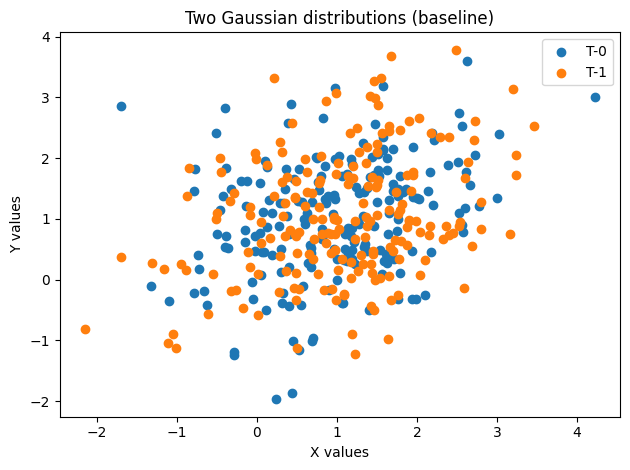

Magnitud del drift: 0.001330433625684524 
p_value: 0.6732673267326733 
Es significativo? False


In [ ]:
# Ejemplo 1: Datos muy similares

# Instanciamos dos Conjuntos de datos muy similares que vamos a visualizar
A= np.random.multivariate_normal(mean=(1,1), cov=((1.0, 0.3), (0.3, 1.0)), size=200)
B= np.random.multivariate_normal(mean=(1,1), cov=((1.0, 0.3), (0.3, 1.0)), size=200)

plt.figure()

plt.title("Ejemplo 1: Datos muy similares")

plt.scatter(A[:,0], A[:,1], label="A")
plt.scatter(B[:,0], B[:,1], label="B")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend()
plt.tight_layout()
plt.show()

# Y ahora calculamos el data drift entre ambos conjuntos
drift= mmd_drift_computation(A, B)

# Como son datos muy similares, la magnitud del drift que nos esperamos es muy baja.
# Además no esperamos que se encuentren diferencias significativas.

print(f"Magnitud del drift: {drift[0]} \np_value: {drift[1]} \nEs significativo? {drift[1] <= TRESHOLD}")

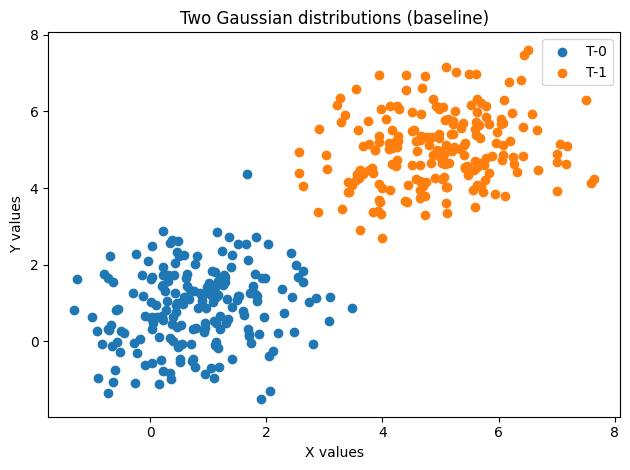

Magnitud del drift: 1.201745291312796 
p_value: 0.009900990099009901 
Es significativo? True


In [ ]:
# Ejemplo 2: Datos muy diferentes

# Instanciamos dos Conjuntos de datos diferentes que vamos a visualizar
A= np.random.multivariate_normal(mean=(1,1), cov=((1.0, 0.3), (0.3, 1.0)), size=200)
B= np.random.multivariate_normal(mean=(5,5), cov=((1.0, 0.3), (0.3, 1.0)), size=200)

plt.figure()

plt.title("Ejemplo 2: Datos muy diferentes")

plt.scatter(A[:,0], A[:,1], label="A")
plt.scatter(B[:,0], B[:,1], label="B")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend()
plt.tight_layout()
plt.show()

# Y ahora calculamos el data drift entre ambos conjuntos
drift= mmd_drift_computation(A, B)

# Como son datos muy diferentes, la magnitud del drift que nos esperamos es alta.
# Además esperamos que se encuentren diferencias significativas.

print(f"Magnitud del drift: {drift[0]} \np_value: {drift[1]} \nEs significativo? {drift[1] <= TRESHOLD}")

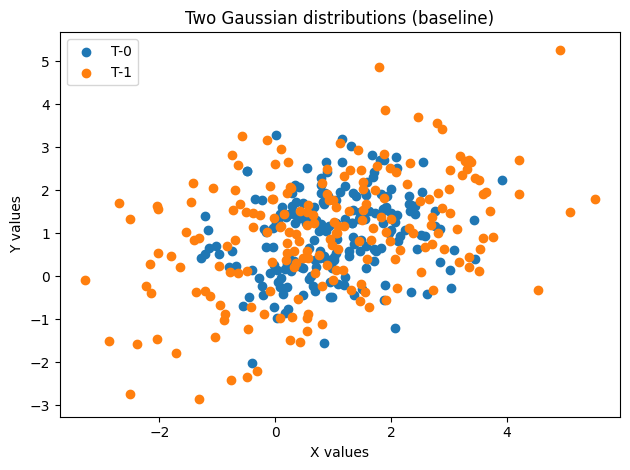

Magnitud del drift: 0.03881649645449903 
p_value: 0.009900990099009901 
Es significativo? True


In [ ]:
# Ejemplo 3: Datos no tan separados

# Instanciamos dos Conjuntos de datos ligeramente diferentes que vamos a visualizar
A= np.random.multivariate_normal(mean=(1,1), cov=((1.0, 0.3), (0.3, 1.0)), size=200)
B= np.random.multivariate_normal(mean=(1,1), cov=((3.0, 1.0), (1.0, 2.0)), size=200)

plt.figure()

plt.title("Ejemplo 3: Datos no tan separados")

plt.scatter(A[:,0], A[:,1], label="A")
plt.scatter(B[:,0], B[:,1], label="B")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend()
plt.tight_layout()
plt.show()

# Y ahora calculamos el data drift entre ambos conjuntos
drift= mmd_drift_computation(A, B)

# Lo detectará?

print(f"Magnitud del drift: {drift[0]} \np_value: {drift[1]} \nEs significativo? {drift[1] <= TRESHOLD}")